In [1]:
import numpy as np
import pickle
from sklearn import metrics
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import os
import pandas as pd

from ast import literal_eval

from process_predictions import get_predictions
from utils import assess_performance, flatten, compare_preds

import random

import warnings
warnings.filterwarnings('ignore')

In [11]:
all_cols = [
    'sectors',
    'subpillars_1d',
    'subpillars_2d'
    ]

In [12]:
DATA_PATH = os.path.join(
    '..', '..', '..', '..', "data", "frameworks_data", 'ukraine_data'
)


test_df = pd.read_csv(os.path.join(DATA_PATH, 'ukraine_final_first_version.csv'))
preds_df = pd.read_csv('ukraine_data_preds.csv')

for col in all_cols:

    test_df[col] = test_df[col].apply(
        lambda x: [item for item in literal_eval(x) if item!='NOT_MAPPED']
    ) 
    preds_df[col] = preds_df[col].apply(
        lambda x: [item for item in literal_eval(x) if item!='NOT_MAPPED']
    )       
    
"""geo_df = pd.read_csv(os.path.join(DATA_PATH, 'test_v0.7.1_geo_pred.csv'))
geo_df['geo_location_pred'] = geo_df['geo_location_pred'].apply(literal_eval)"""

"geo_df = pd.read_csv(os.path.join(DATA_PATH, 'test_v0.7.1_geo_pred.csv'))\ngeo_df['geo_location_pred'] = geo_df['geo_location_pred'].apply(literal_eval)"

In [13]:
preds_df = preds_df.rename(
    columns={'sectors': 'sectors_pred', 'subpillars_1d': 'subpillars_1d_pred', 'subpillars_2d': 'subpillars_2d_pred'}
)
preds_df.head()

,excerpt,sectors_pred,subpillars_2d_pred,subpillars_1d_pred,gender,age,specific_needs_groups,affected_groups,severity,pillars_2d
0,"[28 March 2022, Moldova] \nIn October 2021, th...",[],[],[Context->Economy],[],[],[],[],[],[]
1,"[28 March 2022, Moldova] \nFirst of all, it is...",[],[],[Context->Economy],[],[],[],[],[],[]
2,"[28 March 2022, Moldova] \nSecondly, it influe...",[],[],[Context->Economy],[],[],[],[],[],[]
3,GBV actors on the ground report that although ...,[Protection],[],[],['Female'],[],['GBV survivors'],[],[],[]
4,Difficulties in accessing basic goods and serv...,[Protection],[],[],['Female'],[],['GBV survivors'],[],[],[]


In [14]:
test_df = test_df.rename(
    columns={'sectors': 'sectors_gt', 'subpillars_1d': 'subpillars_1d_gt', 'subpillars_2d': 'subpillars_2d_gt'}
)
test_df.head()

,entry_id,excerpt,sectors_gt,subpillars_2d_gt,subpillars_1d_gt,severity,reliability,specific_needs_groups,geo_location,affected_groups,age,gender
0,551346,"[28 March 2022, Moldova] \nIn October 2021, th...",[],[],[Context->Economy],[],['Fairly Reliable'],[],[720109],[],[],[]
1,542129,GBV actors on the ground report that although ...,[Protection],"[Humanitarian Conditions->Living Standards, Im...",[],[],['Usually reliable'],[],[659697],[],[],[]
2,551347,"[28 March 2022, Moldova] \nFirst of all, it is...",[Logistics],[Impact->Impact On System & Services],[Context->Economy],[],['Fairly Reliable'],[],[720109],[],[],[]
3,551348,"[28 March 2022, Moldova] \nSecondly, it influe...",[],[],[Context->Economy],[],['Fairly Reliable'],[],[720109],[],[],[]
4,542130,"[March 9, 2022, Darabani, Romania] The refugee...","[Food Security, Shelter]",[Capacities & Response->National & Local Actor...,[],[],['Usually reliable'],[],[720058],['Refugees'],[],[]


In [16]:
merged = pd.merge(
    left=test_df[['excerpt', 'sectors_gt', 'subpillars_2d_gt', 'subpillars_1d_gt']],
    right=preds_df[['excerpt', 'sectors_pred', 'subpillars_2d_pred', 'subpillars_1d_pred']],
    on='excerpt',
    how='inner'
)
merged.shape

(11934, 7)

In [22]:
merged

,excerpt,sectors_gt,subpillars_2d_gt,subpillars_1d_gt,sectors_pred,subpillars_2d_pred,subpillars_1d_pred
0,"[28 March 2022, Moldova] \nIn October 2021, th...",[],[],[Context->Economy],[],[],[Context->Economy]
1,GBV actors on the ground report that although ...,[Protection],"[Humanitarian Conditions->Living Standards, Im...",[],[Protection],[],[]
2,GBV actors on the ground report that although ...,[Protection],"[Humanitarian Conditions->Living Standards, Im...",[],[Protection],[],[]
3,GBV actors on the ground report that although ...,"[Protection, Logistics]","[Impact->Impact On System & Services, Humanita...","[Humanitarian Access->Physical Constraints, Co...",[Protection],[],[]
4,GBV actors on the ground report that although ...,"[Protection, Logistics]","[Impact->Impact On System & Services, Humanita...","[Humanitarian Access->Physical Constraints, Co...",[Protection],[],[]
...,...,...,...,...,...,...,...
11929,"In addition, many civilian invaders were forci...",[],[],[Conflict->Protection Threats],[],[Humanitarian Conditions->Physical And Mental ...,[]
11930,"Transport and construction, and now increasing...",[Livelihoods],"[Impact->Drivers/Aggravating Factors, Impact->...",[],[Livelihoods],"[Impact->Driver/Aggravating Factors, Impact->I...",[]
11931,In an April survey conducted by the Central St...,[Livelihoods],[Impact->Impact On System & Services],[],[Livelihoods],"[Impact->Impact On Systems, Services And Netwo...",[]
11932,"Citizens of Georgia, Armenia and Moldova, acco...",[],[],[Context->Legal & Policy],[],[],[Context->Legal & Policy]


In [17]:
test_df = merged[['excerpt', 'sectors_gt', 'subpillars_2d_gt', 'subpillars_1d_gt']]
preds_df = merged[['excerpt', 'sectors_pred', 'subpillars_2d_pred', 'subpillars_1d_pred']]

test_df = test_df.rename(
    columns={'sectors_gt': 'sectors', 'subpillars_1d_gt':'subpillars_1d' ,'subpillars_2d_gt':'subpillars_2d'}
)

preds_df = preds_df.rename(
    columns={'sectors_pred':'sectors','subpillars_1d_pred':'subpillars_1d','subpillars_2d_pred':'subpillars_2d'}
)

## postprocess raw predictions and get results

In [4]:
pillars_1d_tags = ['Covid-19',
 'Casualties',
 'Context',
 'Displacement',
 'Humanitarian Access',
 'Shock/Event',
 'Information And Communication']

pillars_2d_tags = ['At Risk',
 'Priority Interventions',
 'Capacities & Response',
 'Humanitarian Conditions',
 'Impact',
 'Priority Needs']


In [33]:
def get_predictions_all(ratio_proba_threshold, 
    output_columns,
    pillars_2d,
    pillars_1d,
    nb_entries: int, 
    ratio_nb: int):
    
    predictions = {column:[] for column in output_columns }
    for entry_nb in range (nb_entries):
        returns_sectors = ratio_proba_threshold['sectors'][entry_nb]       
        
        returns_subpillars = ratio_proba_threshold['subpillars'][entry_nb] 
        
        subpillars_2d_tags = {
           key: value for key, value in returns_subpillars.items() if\
                key.split('->')[0] in pillars_2d
        }
        subpillars_1d_tags = {
           key: value for key, value in returns_subpillars.items() if\
                key.split('->')[0] in pillars_1d
        }

        ratios_sectors_subpillars_2d =\
            list(returns_sectors.values()) + list(subpillars_2d_tags.values())

        if np.any([item >= ratio_nb for item in ratios_sectors_subpillars_2d]):
            preds_2d = get_preds_entry (subpillars_2d_tags, True, ratio_nb)
            preds_sectors = get_preds_entry (returns_sectors, True, ratio_nb)  

        else:
            preds_2d = []
            preds_sectors = []
            
        predictions['sectors'].append(preds_sectors)
        predictions['subpillars_2d'].append(preds_2d)
        
        preds_1d = get_preds_entry (subpillars_1d_tags, False, ratio_nb)
        predictions['subpillars_1d'].append(preds_1d)
        
        returns_sec_tags = ratio_proba_threshold['secondary_tags'][entry_nb] 
        preds_entry = get_preds_entry (returns_sec_tags, False, ratio_nb)
        
        for secondary_tag in ['age', 'gender', 'affected_groups', 'specific_needs_groups']:
            preds_sec_tag = [
                item.split('->')[1] for item in preds_entry if item.split('->')[0]==secondary_tag 
            ]
            predictions[secondary_tag].append(preds_sec_tag)
        
        severity_tags = {
           key: value for key, value in returns_sec_tags.items() if\
                key.split('->')[0] == 'severity'
        }
        if np.any(['Humanitarian Conditions' in item for item in preds_2d]):
            preds_severity = get_preds_entry (severity_tags, True, ratio_nb, True)
            preds_severity = [item.split('->')[1] for item in preds_severity]
        else:
            preds_severity = []
        predictions['severity'].append(preds_severity)
        
    return predictions
        


def get_preds_entry (preds_column, return_at_least_one=True, ratio_nb=1, return_only_one=False):
    preds_entry = [
        sub_tag for sub_tag in list(preds_column.keys()) if preds_column[sub_tag]>ratio_nb
    ]
    if return_only_one:
        preds_entry = [
            sub_tag for sub_tag in list(preds_column.keys())\
                if preds_column[sub_tag]==max(list(preds_column.values()))
        ]
    if return_at_least_one:
        if len(preds_entry)==0:
            preds_entry = [
                sub_tag for sub_tag in list(preds_column.keys())\
                    if preds_column[sub_tag]==max(list(preds_column.values()))
            ]
    return preds_entry

In [26]:
pickle_file = open("logs/deployment_model_v2.pickle", "rb") ##NAME OF PICKLE FILE
doc = pickle.load(pickle_file)

In [7]:
#get total number of tags
len(doc['preds']['secondary_tags'][0]) + len(doc['preds']['sectors'][0]) + len(doc['preds']['subpillars'][0])

90

In [39]:
def get_predictions_df(doc):
    n_preds = len(doc['preds']['subpillars'])

    final_preds = get_predictions_all(
        doc['preds'], 
        ['sectors', 'subpillars_2d', 'subpillars_1d', 'gender', 'age', 'severity', 'specific_needs_groups', 'affected_groups'],
        pillars_2d=pillars_2d_tags,
        pillars_1d=pillars_1d_tags,
        nb_entries=n_preds, 
        ratio_nb=1)

    predictions_df = test_df[[
    'excerpt', 'entry_id', 'lang', 'analysis_framework_id'
    ]]
    for col in [
        'sectors', 'subpillars_2d', 'subpillars_1d', 
        'gender', 'age', 'specific_needs_groups', 'affected_groups', 'severity']:
        
        predictions_df[col] = final_preds[col]


    return predictions_df

In [40]:
predictions_df = get_predictions_df(doc)
predictions_df.head(2)

,excerpt,entry_id,lang,analysis_framework_id,sectors,subpillars_2d,subpillars_1d,gender,age,specific_needs_groups,affected_groups,severity
0,"During the reporting week, IOM provided medica...",16851,en,137.0,[Health],[Capacities & Response->International Response],[],[Female],[],[Pregnant or Lactating Women],[],[]
1,Primary and secondary net enrollment rates are...,489433,en,1306.0,[Education],"[Humanitarian Conditions->Living Standards, Im...",[],"[Female, Male]",[],[],[],[Major]


In [37]:
#predictions_df.to_csv('logs/total_predictions_deployment.csv', index=None)

In [19]:
cols = ['sectors', 'subpillars_2d', 'subpillars_1d']
raw_results = {}
tot_wrong_ids = {}
for col in cols:
    if col=='sectors':
        ids_not_cross = test_df.sectors.apply(lambda x: 'Cross' not in x)
        gt_sectors = test_df[ids_not_cross].sectors.tolist()
        preds_sectors = preds_df[ids_not_cross].sectors.tolist()
        preds = compare_preds(gt_sectors, preds_sectors)
    else:    
        preds = compare_preds(test_df[col].values, preds_df[col])
        
    results_col = preds['scores']
    raw_results[col] = results_col
    
df_results_raw = pd.DataFrame.from_dict(raw_results, orient='columns')
df_results_raw['names'] = df_results_raw.index
df_results_raw 
#df_results_raw.iloc[[0, 3,4]]

,sectors,subpillars_2d,subpillars_1d,names
proportion_perfect_matches,0.60,0.37,0.45,proportion_perfect_matches
proportion_at_least_one_false,0.40,0.63,0.55,proportion_at_least_one_false
proportion_at_leaset_one_missing,0.24,0.54,0.46,proportion_at_leaset_one_missing


In [15]:
df_results_raw.to_csv('raw_results.csv', index=None)

In [20]:
results_subpillars_2d_original = assess_performance (
    preds_df['subpillars_2d'], 
    test_df['subpillars_2d'].tolist(), 
    sorted(list(set(flatten(test_df['subpillars_2d'])))),
    'subpillars_2d'
    )
results_subpillars_2d_original['names'] = results_subpillars_2d_original.index
results_subpillars_2d_original

,macro_precision,macro_recall,macro_f1_score,1_precision,0_precision,1_recall,0_recall,1_f1_score,0_f1_score,hamming_loss,names
At Risk->People At Risk / Vulnerable,0.488000,0.500000,0.494000,0.000000,0.976000,0.000000,1.000,0.000000,0.988000,0.024000,At Risk->People At Risk / Vulnerable
Capacities & Response->Government & Local Authorities,0.471000,0.500000,0.485000,0.000000,0.942000,0.000000,1.000,0.000000,0.970000,0.058000,Capacities & Response->Government & Local Auth...
Capacities & Response->International,0.424000,0.500000,0.459000,0.000000,0.848000,0.000000,1.000,0.000000,0.918000,0.152000,Capacities & Response->International
Capacities & Response->National & Local Actors,0.484000,0.500000,0.492000,0.000000,0.967000,0.000000,1.000,0.000000,0.983000,0.033000,Capacities & Response->National & Local Actors
Capacities & Response->Number Of People Reached,0.485000,0.500000,0.492000,0.000000,0.970000,0.000000,1.000,0.000000,0.985000,0.030000,Capacities & Response->Number Of People Reached
Humanitarian Conditions->Coping Mechanisms,0.629000,0.735000,0.666000,0.261000,0.997000,0.476000,0.993,0.337000,0.995000,0.010000,Humanitarian Conditions->Coping Mechanisms
Humanitarian Conditions->Living Standards,0.722000,0.753000,0.736000,0.475000,0.968000,0.548000,0.958,0.509000,0.963000,0.068000,Humanitarian Conditions->Living Standards
Humanitarian Conditions->Number Of People In Need,0.692000,0.642000,0.663000,0.390000,0.993000,0.288000,0.996,0.332000,0.995000,0.011000,Humanitarian Conditions->Number Of People In Need
Humanitarian Conditions->Physical & Mental Wellbeing,0.475000,0.500000,0.487000,0.000000,0.950000,0.000000,1.000,0.000000,0.974000,0.050000,Humanitarian Conditions->Physical & Mental Wel...
Impact->Drivers/Aggravating Factors,0.484000,0.500000,0.492000,0.000000,0.969000,0.000000,1.000,0.000000,0.984000,0.031000,Impact->Drivers/Aggravating Factors


In [21]:
results_subpillars_2d_original.to_csv('subpillars_2d_results.csv', index=None)

In [20]:
import matplotlib.patches as mpatches

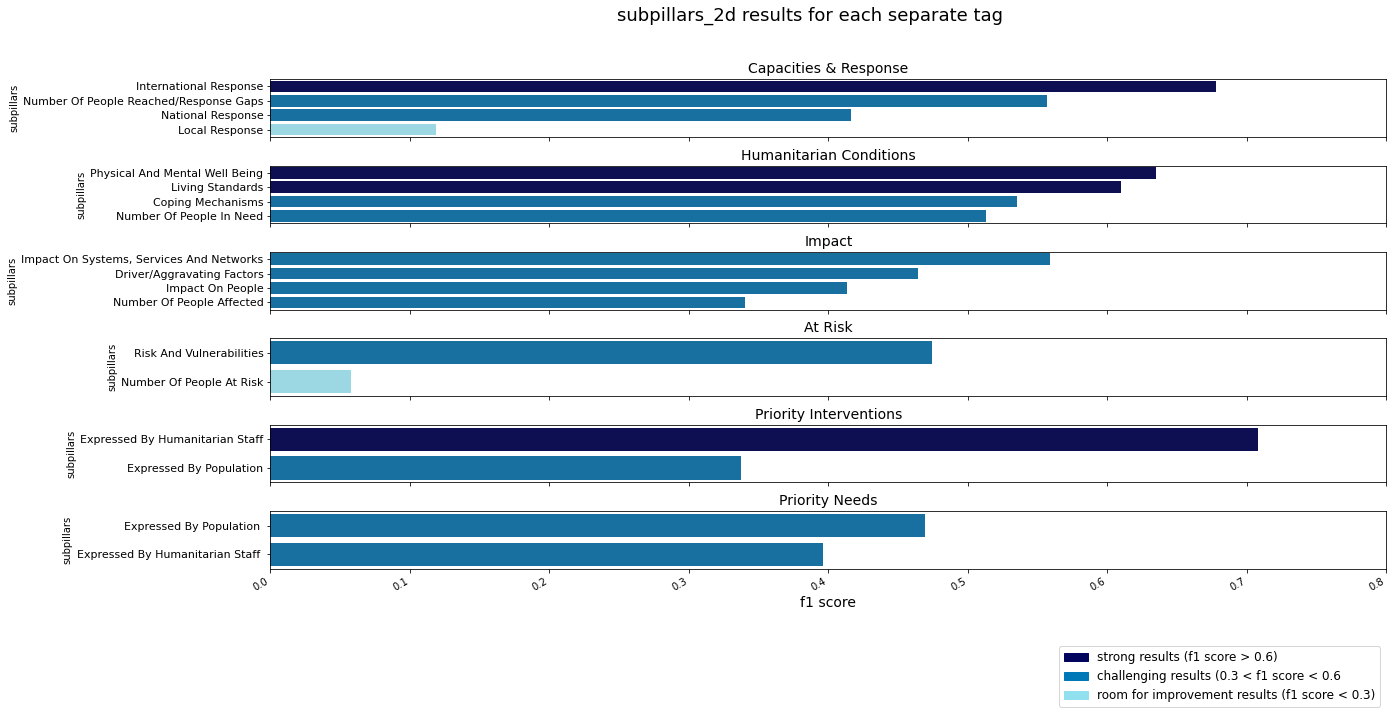

In [31]:
results_subpillars_2d = results_subpillars_2d_original.copy()
results_subpillars_2d.drop(results_subpillars_2d.tail(1).index,inplace=True)
results_subpillars_2d.sort_values(by='1_f1_score', inplace=True, ascending=False)

results_subpillars_2d = results_subpillars_2d[['macro_f1_score', '1_f1_score']].rename(columns={'1_f1_score': 'tag reliability'})
results_subpillars_2d['tag reliability'] = results_subpillars_2d['tag reliability']
results_subpillars_2d['tag_name'] = results_subpillars_2d.index
results_subpillars_2d['pillars'] = results_subpillars_2d['tag_name'].apply(lambda x: x.split('->')[0])
results_subpillars_2d['subpillars'] = results_subpillars_2d['tag_name'].apply(lambda x: x.split('->')[1])
#results_subpillars_2d.sort_values(by='pillars', inplace=True, ascending=True)

results_subpillars_2d.loc['Priority Needs->Expressed By Population', 'subpillars'] = 'Expressed By Population '
results_subpillars_2d.loc['Priority Needs->Expressed By Humanitarian Staff', 'subpillars'] = 'Expressed By Humanitarian Staff '

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(20,10), facecolor='white')


def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = values 
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

custom_palette = {}
for v in list(results_subpillars_2d['subpillars']):
    q = results_subpillars_2d[results_subpillars_2d['subpillars']==v]['tag reliability'].values[0]
    #print(q)
    """if q < 0.3:
        custom_palette[v] = '#caf0f8'"""
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_pillars = {
    'At Risk': 3,
 'Priority Interventions': 4,
 'Capacities & Response': 0,
 'Humanitarian Conditions': 1,
 'Impact': 2,
 'Priority Needs': 5
}

for j in range (6):
    pillar_2d_tmp = pillars_2d_tags[j]
    i = ordered_pillars[pillar_2d_tmp]
    subpilars_tmp = results_subpillars_2d[results_subpillars_2d.tag_name.apply(
        lambda x: x.split('->')[0] == pillar_2d_tmp
    )]
    
    y = subpilars_tmp['tag reliability']
    axes[i].set_title(f'{pillar_2d_tmp}', fontsize=14)
    plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].set_xlim([0, 0.8])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=subpilars_tmp['subpillars'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]
fig.suptitle('subpillars_2d results for each separate tag', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))


plt.savefig('results_vizu/subpillars2d_with_scores.png', bbox_inches="tight")


## 1d

In [21]:
results_subpillars_1d_original = assess_performance (
    preds_df['subpillars_1d'], 
    test_df['subpillars_1d'].tolist(), 
    sorted(list(set(flatten(test_df['subpillars_1d'])))),
    'subpillars_1d'
    )
results_subpillars_1d_original['names'] = results_subpillars_1d_original.index
results_subpillars_1d_original

,macro_precision,macro_recall,macro_f1_score,1_precision,0_precision,1_recall,0_recall,1_f1_score,0_f1_score,hamming_loss,names
Communication & Information->Challenges & Barriers,0.498000,0.500000,0.499,0.000000,0.996000,0.000000,1.000000,0.000000,0.998000,0.004000,Communication & Information->Challenges & Barr...
Communication & Information->Communication Channels & Means,0.493000,0.500000,0.496,0.000000,0.985000,0.000000,1.000000,0.000000,0.992000,0.015000,Communication & Information->Communication Cha...
"Communication & Information->Knowledge, Gaps & Misinformation",0.497000,0.500000,0.499,0.000000,0.995000,0.000000,1.000000,0.000000,0.997000,0.005000,"Communication & Information->Knowledge, Gaps &..."
Conflict->Casualties & Missings,0.441000,0.500000,0.468,0.000000,0.881000,0.000000,1.000000,0.000000,0.937000,0.119000,Conflict->Casualties & Missings
Conflict->Combatants And Affected Population,0.486000,0.500000,0.493,0.000000,0.971000,0.000000,1.000000,0.000000,0.985000,0.029000,Conflict->Combatants And Affected Population
Conflict->Conflict Damages,0.465000,0.500000,0.482,0.000000,0.930000,0.000000,1.000000,0.000000,0.964000,0.070000,Conflict->Conflict Damages
Conflict->Conflict Event,0.427000,0.500000,0.460,0.000000,0.854000,0.000000,1.000000,0.000000,0.921000,0.146000,Conflict->Conflict Event
Conflict->Drivers & Aggravating Factors,0.490000,0.500000,0.495,0.000000,0.979000,0.000000,1.000000,0.000000,0.990000,0.021000,Conflict->Drivers & Aggravating Factors
Conflict->Protection Threats,0.486000,0.500000,0.493,0.000000,0.972000,0.000000,1.000000,0.000000,0.986000,0.028000,Conflict->Protection Threats
Conflict->Security Measures,0.496000,0.500000,0.498,0.000000,0.992000,0.000000,1.000000,0.000000,0.996000,0.008000,Conflict->Security Measures


In [20]:
results_subpillars_1d_original.to_csv('subpillars_1d_results.csv', index=None)

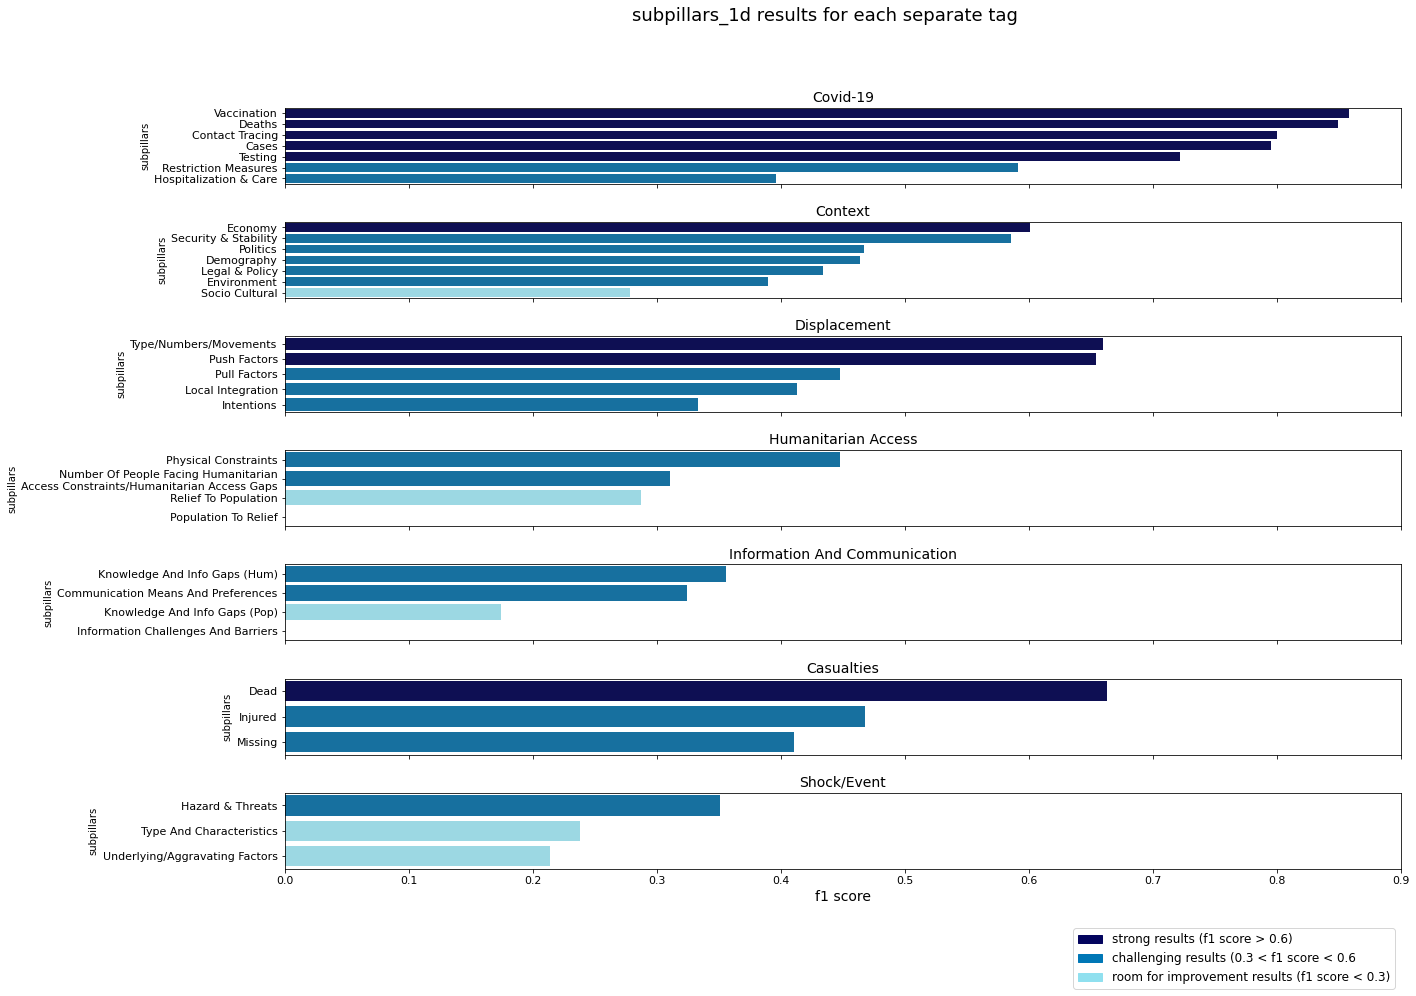

In [23]:
results_subpillars_1d = results_subpillars_1d_original.copy()
results_subpillars_1d.drop(results_subpillars_1d.tail(1).index,inplace=True)
results_subpillars_1d.sort_values(by='1_f1_score', ascending=False, inplace=True)

results_subpillars_1d = results_subpillars_1d[['macro_f1_score', '1_f1_score']].rename(columns={'1_f1_score': 'f1 score'})
results_subpillars_1d['tag_name'] = results_subpillars_1d.index
results_subpillars_1d['pillars'] = results_subpillars_1d['tag_name'].apply(lambda x: x.split('->')[0])
results_subpillars_1d['subpillars'] = results_subpillars_1d['tag_name'].apply(lambda x: x.split('->')[1])

results_subpillars_1d.loc['Humanitarian Access->Number Of People Facing Humanitarian Access Constraints/Humanitarian Access Gaps', 'subpillars'] =\
     'Number Of People Facing Humanitarian\nAccess Constraints/Humanitarian Access Gaps'

fig, axes = plt.subplots(len(pillars_1d_tags), 1, sharex=True, figsize=(20,14), facecolor='white')
custom_palette = {}
for v in list(results_subpillars_1d['subpillars']):
    q = results_subpillars_1d[results_subpillars_1d['subpillars']==v]['f1 score'].values[0]

    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'

ordered_pillars = {
 'Covid-19': 0,
 'Casualties': 5,
 'Context': 1,
 'Displacement': 2,
 'Humanitarian Access': 3,
 'Shock/Event': 6,
 'Information And Communication': 4
}

for j in range (7):
    pillar_1d_tmp = pillars_1d_tags[j]
    i = ordered_pillars[pillar_1d_tmp]
    subpilars_tmp = results_subpillars_1d[results_subpillars_1d.tag_name.apply(
        lambda x: x.split('->')[0] == pillar_1d_tmp
    )]
    
    y = subpilars_tmp['f1 score']
    axes[i].set_title(f'{pillar_1d_tmp}', fontsize=14)
    #plt.gcf().autofmt_xdate()
    #axes[i].xaxis.set_visible(False)
    axes[i].xaxis.set_tick_params(labelsize=11)
    #axes[i].xaxis.set_title(labelsize='large')
    axes[i].set_xlim([0, 0.9])
    axes[i].yaxis.set_tick_params(labelsize=11)
    #axes[i].axvline(x=0.5)
    sns.barplot(ax=axes[i], y=subpilars_tmp['subpillars'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

fig.suptitle('subpillars_1d results for each separate tag', fontsize=18)

#unreliable_tags = mpatches.Patch(color='#caf0f8', label='unreliable tags')
handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))

plt.savefig('results_vizu/subpillars1d_with_scores.png', bbox_inches="tight")



In [28]:
[item for item in gt_sectors if any(['wash' in it.lower() for it in item])]

[['Wash'],
 ['Health', 'Education', 'Wash'],
 ['Wash', 'Logistics'],
 ['Wash'],
 ['Health', 'Food Security', 'Wash', 'Logistics'],
 ['Food Security', 'Wash', 'Shelter', 'Logistics'],
 ['Wash'],
 ['Health', 'Wash'],
 ['Health', 'Food Security', 'Wash'],
 ['Food Security', 'Wash'],
 ['Food Security', 'Wash'],
 ['Nutrition', 'Food Security', 'Wash', 'Logistics'],
 ['Food Security', 'Wash'],
 ['Health', 'Wash', 'Logistics'],
 ['Food Security', 'Wash'],
 ['Food Security', 'Wash', 'Shelter'],
 ['Food Security', 'Wash'],
 ['Wash', 'Food Security', 'Protection', 'Logistics'],
 ['Wash'],
 ['Health', 'Food Security', 'Wash', 'Shelter'],
 ['Food Security', 'Wash'],
 ['Wash'],
 ['Wash'],
 ['Food Security', 'Wash', 'Shelter'],
 ['Wash', 'Shelter', 'Livelihoods'],
 ['Wash'],
 ['Wash'],
 ['Wash'],
 ['Wash', 'Shelter', 'Food Security', 'Logistics', 'Health'],
 ['Protection', 'Wash', 'Food Security', 'Logistics'],
 ['Wash'],
 ['Health', 'Food Security', 'Wash'],
 ['Health', 'Food Security', 'Wash'],
 [

In [34]:
test_df

,excerpt,sectors,subpillars_2d,subpillars_1d
0,"[28 March 2022, Moldova] \nIn October 2021, th...",[],[],[Context->Economy]
1,GBV actors on the ground report that although ...,[Protection],"[Humanitarian Conditions->Living Standards, Im...",[]
2,GBV actors on the ground report that although ...,[Protection],"[Humanitarian Conditions->Living Standards, Im...",[]
3,GBV actors on the ground report that although ...,"[Protection, Logistics]","[Impact->Impact On System & Services, Humanita...","[Humanitarian Access->Physical Constraints, Co..."
4,GBV actors on the ground report that although ...,"[Protection, Logistics]","[Impact->Impact On System & Services, Humanita...","[Humanitarian Access->Physical Constraints, Co..."
...,...,...,...,...
11929,"In addition, many civilian invaders were forci...",[],[],[Conflict->Protection Threats]
11930,"Transport and construction, and now increasing...",[Livelihoods],"[Impact->Drivers/Aggravating Factors, Impact->...",[]
11931,In an April survey conducted by the Central St...,[Livelihoods],[Impact->Impact On System & Services],[]
11932,"Citizens of Georgia, Armenia and Moldova, acco...",[],[],[Context->Legal & Policy]


In [38]:
[item for item in preds_sectors if any(['protection' == it.lower() for it in item])]

[['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Health', 'Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Health', 'Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Protection'],
 ['Education', 'Health', 'Protection'],
 ['Education', 'Protection'],
 ['Food Security', 'Health', 'Livelihoods', 'Protection', 'Shelter', 'Wash'],
 ['Protection'],
 ['Protection'],

In [31]:
ids_not_cross = test_df.sectors.apply(lambda x: 'Cross' not in x)
gt_sectors = test_df[ids_not_cross].sectors.tolist()
preds_sectors = preds_df[ids_not_cross].sectors.tolist()
#results_col = compare_preds(gt_sectors, preds_sectors)

preds_sectors = [[it if it!='WASH' else 'Wash' for it in item] for item in preds_sectors]

In [39]:
results_sectors_original = assess_performance (
    preds_sectors, 
    gt_sectors, 
    sorted(list(set(flatten(gt_sectors)))),
    'sectors'
    )

results_sectors_original['names'] = results_sectors_original.index
results_sectors_original[['1_precision', '1_recall', '1_f1_score']]

,1_precision,1_recall,1_f1_score
Agriculture,0.6630,0.6080,0.6340
Education,0.7910,0.8600,0.8240
Food Security,0.7730,0.7890,0.7810
Health,0.7480,0.8580,0.7990
Livelihoods,0.6730,0.4890,0.5670
Logistics,0.5280,0.2620,0.3510
Nutrition,0.7500,0.6230,0.6810
Protection,0.4660,0.5450,0.5030
Shelter,0.6500,0.5760,0.6110
Wash,0.7950,0.7730,0.7840


In [25]:
results_sectors_original.to_csv('results_sectors.csv', index = None)

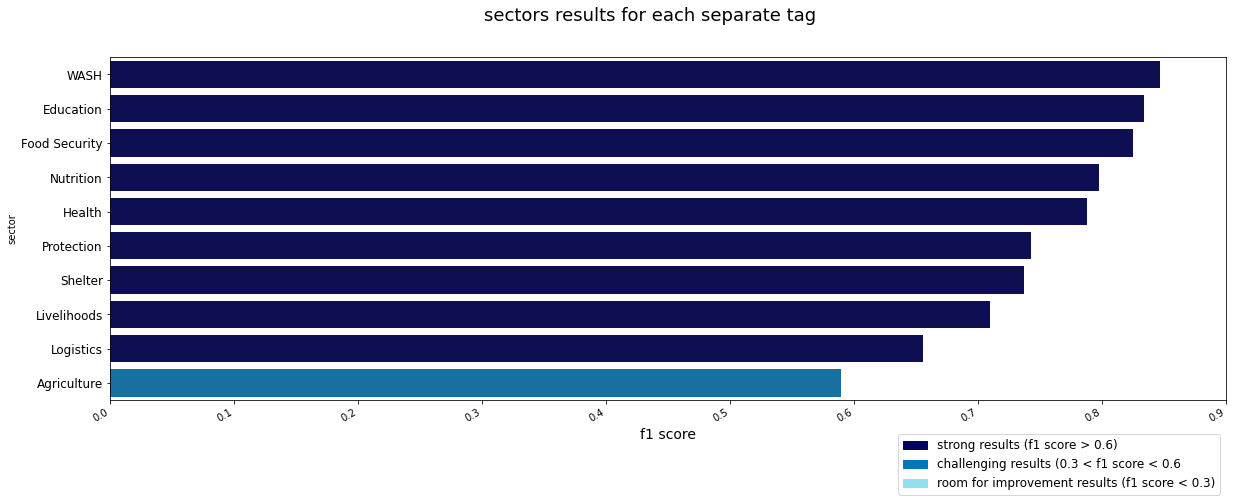

In [25]:
results_sectors = results_sectors_original.copy()
results_sectors.drop(results_sectors.tail(1).index,inplace=True)
results_sectors.sort_values(by='1_f1_score', ascending=False, inplace=True)
results_sectors = results_sectors[['macro_f1_score', '1_f1_score']].rename(columns={'1_f1_score': 'tag reliability'})
results_sectors['tag reliability'] = results_sectors['tag reliability']
results_sectors['sector'] = results_sectors.index

custom_palette = {}
for v in list(results_sectors['sector']):
    q = results_sectors[results_sectors['sector']==v]['tag reliability'].values[0]
    
    if q < 0.3:
        custom_palette[v] = '#90e0ef'
    elif q < 0.6:
        custom_palette[v] = '#0077b6'
    else:
        custom_palette[v] = '#03045e'
    
fig = plt.figure(figsize=(20,7), facecolor='white')
ax = fig.add_subplot()

y = results_sectors['tag reliability']
plt.gcf().autofmt_xdate()
#ax.xaxis.set_visible(False)
ax.set_xlim([0, 0.9])
ax.yaxis.set_tick_params(labelsize=12)
sns.barplot(ax=ax, y=results_sectors['sector'], x=y, palette=custom_palette).set(xlabel=None)#colors_from_values(y, "rocket_r"))
plt.xlabel('f1 score', fontsize=14)

usually_reliable_tags = mpatches.Patch(color='#03045e', label='strong results (f1 score > 0.6)')
fairly_reliable_tags = mpatches.Patch(color='#0077b6', label='challenging results (0.3 < f1 score < 0.6')
not_usually_reliable_tags = mpatches.Patch(color='#90e0ef', label='room for improvement results (f1 score < 0.3)')

fig.suptitle('sectors results for each separate tag', fontsize=18)
#unreliable_tags = mpatches.Patch(color='#caf0f8', label='unreliable tags')
handles = [usually_reliable_tags, fairly_reliable_tags, not_usually_reliable_tags]

fig.legend(handles=handles, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))


plt.savefig('results_vizu/sectors_with_scores.png', bbox_inches="tight")



## Create testing df for taggers (not needed for predictions and deployment)

In [16]:
geo_df = geo_df.rename(columns={'geo_location_pred': 'geo_location'})
predictions_df = predictions_df.merge(
    right=geo_df,
    on='entry_id'
)

In [17]:
geo_df.columns

Index(['entry_id', 'geo_location'], dtype='object')

In [18]:
def get_clean_output(x):
    return '\n'.join([str({
        '{:s}'.format('\u0332'.join(key)): value}
    ) for key, value in x.items()])

def clean_excerpt(x):
    n = 12
    split_text = x.split(' ')
    final_list = []
    for i in range(0, len(split_text), n): 
        final_list.append(' '.join(split_text[i:i + n]))
    return '\n'.join(final_list)

In [24]:
predictions_df['test_primary_tags'] = test_df.apply(
    lambda x: x.sectors + x.subpillars_1d + x.subpillars_2d + [x.analysis_framework_id], axis=1
)

en_df = predictions_df[predictions_df.lang == 'en']
en_df["test_primary_tags"] = en_df["test_primary_tags"].apply(str)
ids = en_df.groupby("test_primary_tags")["entry_id"].agg(list).values
unique_ids = [list(np.unique(list_)) for list_ in ids]

tot_ids = sorted(unique_ids, key=len)
ids = [
    random.sample(id_tmp, int(len(id_tmp) * 0.02)) for id_tmp in tot_ids
]
taggers_ids = flatten(ids)

tested_cols = [
    'sectors', 'subpillars_2d', 'subpillars_1d', 'age', 'gender', 'severity', 'geo_location' 
]
kept_cols = ['entry_id', 'excerpt'] + tested_cols
taggers_df = predictions_df[predictions_df.entry_id.isin(taggers_ids)][kept_cols]
taggers_df['excerpt'] = taggers_df['excerpt'].apply(clean_excerpt)
taggers_df['predictions'] = taggers_df.apply(
    lambda x: get_clean_output({col:x[col] for col in tested_cols}), axis=1
)
taggers_df['wrong_tags'] = taggers_df.apply(
    lambda x: get_clean_output({col:[] for col in tested_cols}), axis=1
)
taggers_df['missing_tags'] = taggers_df.apply(
    lambda x: get_clean_output({col:[] for col in tested_cols}), axis=1
)
taggers_df.sectors.apply(lambda x: len(x)>0).sum()

taggers_df['specific_needs_groups'] = '[]'
taggers_df['affected_groups'] = '[]'

taggers_df[[
    'entry_id', 
    'excerpt', 
    'predictions', 
    'wrong_tags', 
    'missing_tags',
    'specific_needs_groups',
    'affected_groups'
]].to_csv(
    'models_testing_round3.csv', index=None
)


In [25]:
taggers_df.sectors.apply(lambda x: len(x)>0).sum() / taggers_df.shape[0]

0.6065573770491803

In [21]:
pd.read_csv('models_testing_round3.csv')

,entry_id,excerpt,predictions,wrong_tags,missing_tags,specific_needs_groups,affected_groups
0,489933,"[31st Aug 2021, Adamawa State] (Cholera) The t...",{'s̲e̲c̲t̲o̲r̲s': ['Health']}\n{'s̲u̲b̲p̲i̲l̲l...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
1,183653,"[7th October 2020, Overall Syria] The Ministry...",{'s̲e̲c̲t̲o̲r̲s': ['Health']}\n{'s̲u̲b̲p̲i̲l̲l...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
2,271808,"[February 25, As Sweida] The Director of Healt...",{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
3,174921,In several UNHCR-managed displacement sites in...,{'s̲e̲c̲t̲o̲r̲s': ['Health']}\n{'s̲u̲b̲p̲i̲l̲l...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
4,174554,"[ 1st July 2020, Borno states] Depicts the nom...",{'s̲e̲c̲t̲o̲r̲s': ['Food Security']}\n{'s̲u̲b̲...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
...,...,...,...,...,...,...,...
98,303849,"Other evidence, including hate statements tagg...",{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
99,272168,(S)GBV is a plight in Afghanistan. In the bigg...,{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
100,319997,"Fighting was reported mainly in Kandahar, Helm...",{'s̲e̲c̲t̲o̲r̲s': ['Protection']}\n{'s̲u̲b̲p̲i...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
101,338477,- Project and programme implementors need to e...,{'s̲e̲c̲t̲o̲r̲s': ['Livelihoods']}\n{'s̲u̲b̲p̲...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,{'s̲e̲c̲t̲o̲r̲s': []}\n{'s̲u̲b̲p̲i̲l̲l̲a̲r̲s̲_...,[],[]
